# BabyFat Data

### Hongzhi Liu, Lixia Yi, Yanran Wang, Jianmin Chen

In [10]:
library(gvlma);library(xtable);library(car);library(glmnet);library(psych);library(pls);library(boot)
library(ggplot2);library(gridExtra);library(ggfortify);library(grid);library(IRdisplay);library(repr)
data <- read.csv(file = "../Data/BodyFat.csv");data <- data[, -c(1)] #delete the index of instances
options(warn=-1)

## Part 1 Data Background and EDA
The percentage of body fat plays an important role in various field of human health. However, an accurate measurement of body fat is costly and inconvenient. In this project, our goal is to come up with a simple but moderately accurate way of estimating the percentage of body fat of males based on readily available clinical measurements using only a measuring tape.

In the dataset collected during the 1980s, age, weight, height, and 10 body circumference measurements were recorded for 252 men. Each man's percentage of body fat was accurately estimated by an underwater weighing technique.

First, using `str()` we can observe that all variables are `float`s except age, which is an `integer`, and there are no obvious factorial variables. Thus, we drew a scatter plot to explore the relationship between the dependent variable and each independent variable using the raw data set. The scatter plots:

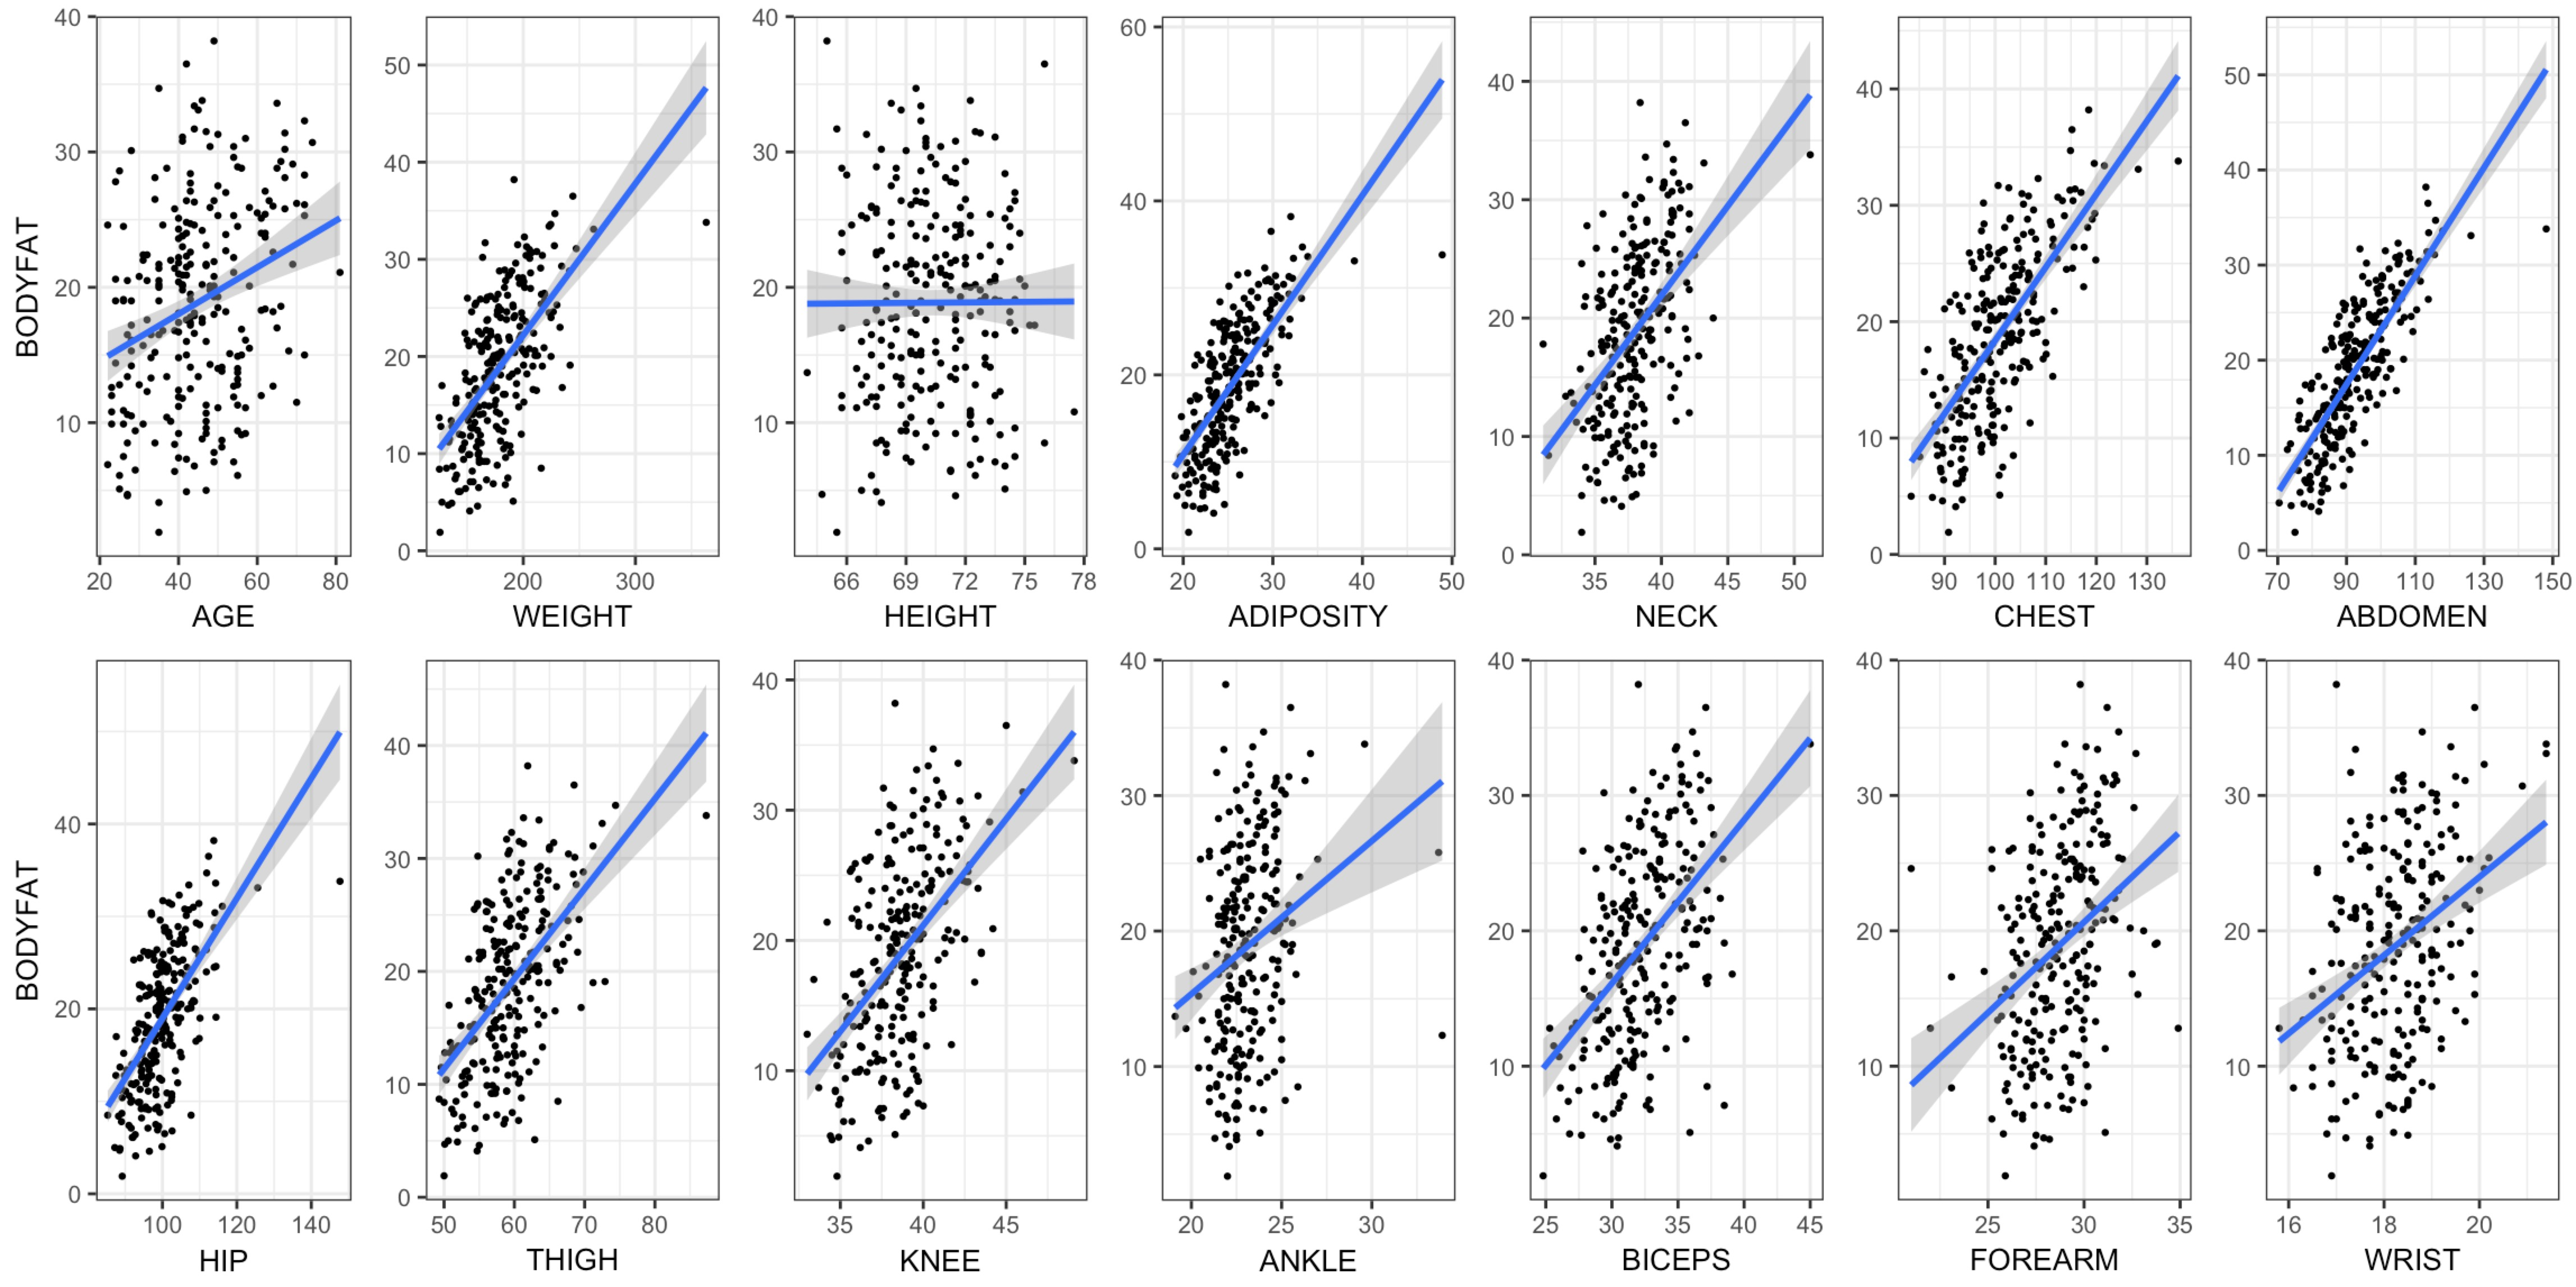

In [24]:
library("IRdisplay")
display_png(file="../Image/Scatter Plot.jpg")  

It could be observed in the scatter plots that Bodyfat is linearly related with multiple independent variables which suggests us to establish a linear model. 
Noticable, almost all scatter plots show a similar trend, which suggests that we may have multicollinearity problems in a linear model. Meanwhile, there are outliers in some of the plots, which means that there exists some abnormal datapoints. Besides, notice that age and Bodyfat also shows approximate linearity, we don't have to consider age as a factor.

For these abnormal datapoints shown above, we create 3 rules to decide whether to delete them: 
* Data with impossible values: 182(0 Bodyfat value),216(extremely high bodyfat value),42(only 29.5 in Height)
* Values recalculated differ too much between 2 measurements of body component: 96 (Density and Bodyfat)
* Extreme values: 79,39,31
For point 182, 216, 42 and 96, we deleted them before fitting the model while for the other points, we kept them as suspected outliers.

## Part 2 Multivariable linear regression and diagnostics
Now, we use BODYFAT as our dependent variable and other 14 variables as our independent variables to fit a multivariate linear regression model. We found out that the adjusted R-square of the model is 0.72 which indicates that it is reasonable to use a linear model. Furthermore, we discovered several variables’ VIF values are extremely large, which indicates that multicollinearity exists in this model. 
The VIF table:

In [12]:
model.raw <- lm(BODYFAT ~ ., data = data.1)

| weight | adiposity | height | hip   | abdomen | chest | thigh | knee | neck | biceps | wrist | age  | foream | ankle |
|--------|-----------|--------|-------|---------|-------|-------|------|------|--------|-------|------|--------|-------|
| 144.97 | 120.35    | 28.64  | 14.61 | 12.88   | 10.71 | 7.9   | 4.76 | 4.34 | 3.68   | 3.29  | 2.27 | 2.19   | 1.97  |

The diagnostic plots:

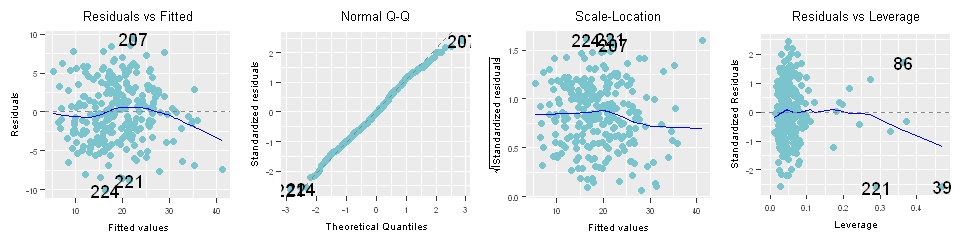

In [13]:
data.3 = data[-c(182, 216, 96, 42, 39, 31, 36, 41, 54, 86, 106, 159, 163, 175, 206, 216, 221),-2]
options(repr.plot.width=8, repr.plot.height=2)
autoplot(model.raw,colour='cadetblue3',nrow=1,ncol=4)+theme(text = element_text(size=6),plot.title = element_text(hjust = 0.5,size=8))

From these plots, it could be supposed that there exist outliers in our model. So, we need to clean the data. At first, we drew the Cook’s Distance plot and removed points which have Cook’s distance larger than 4/(n-p). Each time, we removed one point and finally we removed points 39, 221, 86, 41 and 163. Then, we used the hat matrix method to remove high leverage points, that is, 31, 36, 54, 106, 159, 175, 206, 216. We fit linear model again using the cleaned dataset. The diagnostic plots are shown below:


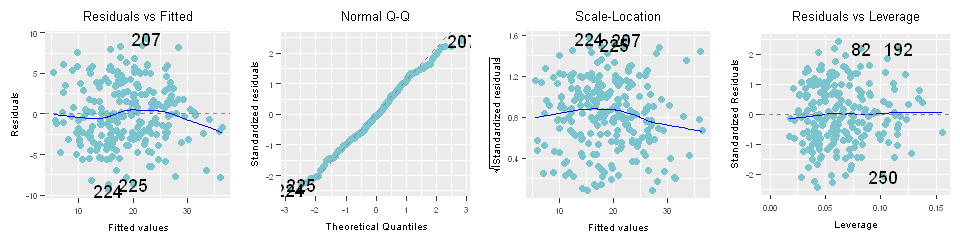

In [14]:
model.full <- lm(BODYFAT ~ ., data = data.3);options(repr.plot.width=8, repr.plot.height=2)
autoplot(model.full,colour='cadetblue3',nrow=1,ncol=4)+theme(text = element_text(size=6),plot.title = element_text(hjust = 0.5,size=8))

We can find that there is no obvious trend in the residual plot and the homoscedasticity assumption is not obviously violated. However, the Normal QQ Plot shows that the distribution of error term might slightly departure from normal distribution. Therefore, more rigorous tests were proceeded. We can find out that our model passes all tests ([Pena, 2006](#Pena, 2006)) except the normality test. However, when other fundamental assumptions hold, and the normality assumption is not violated obviously, a multivariate linear model is still suitable, so we still think that it can be applied.

In [15]:
r1 = c('Independence','Homoscedasticity','Linearity','Normality')
r2 = c('Durbin-Watson Test','Score Test','Link Function Test','Shapiro-Wilk Test')
r3 = c(0.15,0.77,0.08,0.19);r = data.frame('Assumption'=r1,'Test'=r2,'p-value'=r3);r

Assumption,Test,p.value
Independence,Durbin-Watson Test,0.15
Homoscedasticity,Score Test,0.77
Linearity,Link Function Test,0.08
Normality,Shapiro-Wilk Test,0.19


## Part 3 model selection
Our main goal is to get a model predicting bodyfat, which is accurate enough but also simple and robust. It had been shown in Part 2 that there exists multicollinearity among independent variables which may cause unstable estimations of parameters and will lead to difficulty in explaining the model. We conducted several model selection procedures to solve that problem. Among all kinds of model selection methods, we mainly used subset selection methods and the Lasso method. We didn't use stepwise regression though it is an useful tool in model selection since it may lead to wrong models under serious multicollinearity.

(1). Subset selections using Mallow Cp as criterion
According to the Cp plot, we selected variable 2,7,12,14 in the final model. That is,

BODYFAT~WEIGHT+ABDOMEN+BICEPS+WRIST

(2). Lasso method
Lasso is a powerful method under the multicollinearity settings. High influencial points and high leverage points may affect the selection result but we had already remedied most of that in Part 2. We discovered that, it is plausible to contain 3 or 4 variables in the Lasso procedure. The plots show the variable selection results from lasso. 
After selecting variables, we use the selected ones to fit a multivariable linear regression model again. The Lasso model generates 2 more models:

a.BODYFAT~AGE+HEIGHT+ABDOMEN+WRIST

b.BOFYFAT~HEIGHT+ABODOMEN+WRIST

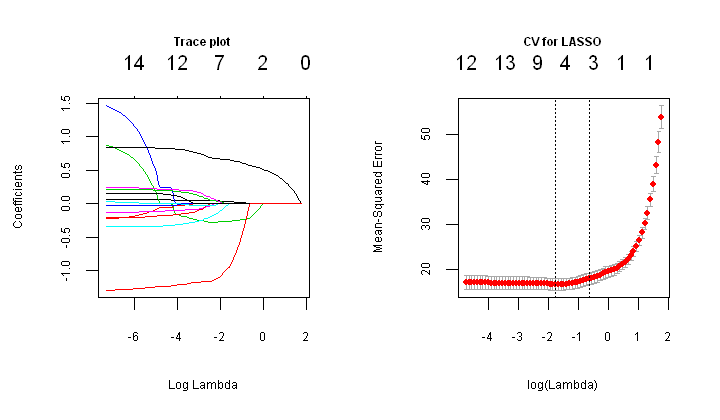

In [16]:
y = as.matrix(data.3[,1]);x = as.matrix(data.3[,-1])
set.seed(15);cvfit = cv.glmnet(x = x, y = y, family = "gaussian", nlambda = 100, alpha = 1, standardize=TRUE,nfolds=10)
fit = glmnet(x = x, y = y, family = "gaussian",lambda=cvfit$lambda.1se,alpha=1, standardize=TRUE)
options(repr.plot.width=6, repr.plot.height=3.5);par(mfrow=c(1,2))
plot(cvfit$glmnet.fit,cex.axis=0.6,cex.lab=0.6,cex=0.6,xvar='lambda');title("Trace plot",line = 2.2,cex.main=0.6)
plot(cvfit,cex.axis=0.6,cex.lab=0.6,cex=0.6);title("CV for LASSO", line = 2.2,cex.main=0.6)
par(mfrow=c(1,1))

Now we have 4 candidate models including the full model. In order to find the best model, we conducted a 10-fold cross-validation 100 times on each of the model and calculated the mean of MSE. In the following table, we demonstrate the CV-MSE of 4 models as well as the adjusted R-square with all observations used. From the table we can see that the the difference in MSE is not large compared with its own scale. Also, the adjusted R square do not differ much. Hence, we finally picked the model with variable HEIGHT, ABDOMEN and WRIST as the final model, for it is simple for application, robust and accurate enough.

| method     | cv.error | AdjR | variables                   |
|------------|----------|------|-----------------------------|
| Full Model | 16.64    | 0.71 | All                         |
| Mallow Cp  | 15.96    | 0.71 | WEIGHT+ABDOMEN+BICEPS+WRIST |
| Lasso      | 16.23    | 0.71 | AGE+HEIGHT+ABDOMEN+WRIST    |
| Lasso      | 16.36    | 0.70 | HEIGHT+ABDOMEN+WRIST        |

Summary statistics of the final model:

In [17]:
m.final = lm(BODYFAT~HEIGHT+ABDOMEN+WRIST,data=data.3)
xtable(m.final)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4.7931074,7.81462109,0.6133512,5.402450e-01
HEIGHT,-0.3872680,0.11195458,-3.4591530,6.446650e-04
ABDOMEN,0.7158812,0.03385491,21.1455614,4.991645e-56
WRIST,-1.3582637,0.39827061,-3.4104040,7.649647e-04


Diagnostic plots:

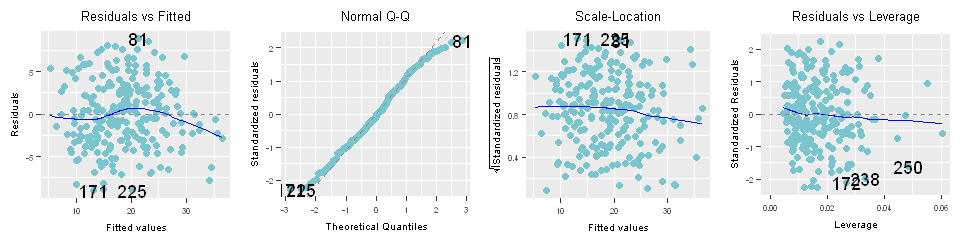

In [18]:
options(repr.plot.width=8, repr.plot.height=2)
autoplot(m.final,colour='cadetblue3',nrow=1,ncol=4)+theme(text = element_text(size=6),plot.title = element_text(hjust = 0.5,size=8))

## Conclusion

The final model is :
$$Bodyfat = 10.1006 - 0.4428Height + 0.7198Abdomen - 1.4557Wrist$$
Simplifying it:
$$Bodyfat = 10 - 0.5Height(inch) + 0.7Abdomen(cm) - 1.5Wrist(cm)$$

A possible rule of thumb: Abdomen multiplied by 0.7, minus wrist multiplied by 1.5, minus height multiplied by 0.4 and add 5. And we produced a coefficient table to deal with different unit of variables.

|      | height | abdomen | wrist |
|------|--------|---------|-------|
| inch | -0.4   | 1.8     | -3.5  |
| cm   | -0.15  | 0.7     | -1.5  |

In our project, it is good to assume that the body consists of two distinctive compartments: The body fat, the part we are concerning and the fat-free mass (FFM), which includes all the rest of the body apart from fat ([Durnin, 1974](#Durnin, 1974)). It is intuitive to think that the circumference of our abdomen (belly) is a good parameter for measuring the body fat, while the circumference of our wrist, a part with minimum fat, is a good indicator for the FFM part of our body. Furthermore, as we've discussed previously, there exists multicollinearity between the variables given, hence the variable `Height` serves as a correction term instead of an unreasonable variable which contributes negatively to the body fat.

**Inference about Relationship:** There is clearly a multivariate linear relationship between dependent variable body fat percentage and independent variables Height, Abdomen, and Wrist. The adjusted R-square for final model is 0.7, which means the model explains 70% of all the variation in Body fat percentage. And all 3 variables, Height, Abdomen, and Wrist are significant at the 0.01 level. Also, according to this model, a male is expected to lose about 0.15% in body fat percentage when his height increases 1 cm, gain about 0.72% in body fat percentage when his abdomen increases 1 cm and lose about 1.36% in body fat percentage when his wrist increases 1 cm.

**Strength:** One advantage of the model is its simplicity. To estimate our body fat, we only need to know three values: Our height, the circumference of our abdomen and the circumference of our wrist. Considering most of us already know our height and it is very easy to measure the the circumference of our abdomen and wrist, our model can provide a fairly good estimate of the body fat without much effort.

**Weakness:** The disadvantage of the model lies in its accuracy and adaptation. After we've simplified the model, we'll loose precision in the estimation of body fat. Moreover, components in our body change with age, gender and other factors. For example, growing children are different to adults, our bones become smaller when we get older and females have more body fat due to their nature. Since the data on which we fit our model was gathered only from males who are mostly in their middle-age, the model will only work well on the corresponding population.

**Example Usage:** For an average man of 92cm in abdomen, 178cm in height, 18cm in wrist, his predicted body fat % would be around 15.7%. 

## Contribution
| Name         | Contibution                                                                     |
|--------------|---------------------------------------------------------------------------------|
| Hongzhi Liu  | Completed the first version of analysis and code.                               |
| Jianmin Chen | Reorganized Hongzhi's work, added new content. Redrew the images and table.     |
| Yanran Wang  | Summarized our work, made slides for presentation.                              |
| Lixia Yi     | Revised the Rmarkdown file. Tested and maintained the GitHub repo and notebook. |

## Reference
* <a id="Durnin, 1974"></a>Durnin, J. V., & Womersley, J. V. G. A. (1974). Body fat assessed from total body density and its estimation from skinfold thickness: measurements on 481 men and women aged from 16 to 72 years. British journal of nutrition, 32(1), 77-97.
* <a id="Pena, 2006"></a>Peña, Edsel A., and Elizabeth H. Slate. “Global Validation of Linear Model Assumptions.” Journal of the American Statistical Association 101.473 (2006): 341. PMC. Web. 4 Feb. 2018.
